In [1]:
# This cell can be deleted when the package is installed
# It is used to add the package to the path when running the notebook in development mode
import _add_path

# Création d'une modélisation 2D via script

Afin de créer une simulation 2D, il est nécessaire de :
 
  - créer une instance "prev_sim2D" en lui passant en argument le chemin d'accès complet et le nom générique de la simulation
  - définir un contour vectoriel/polygone délimitant la zone de travail
  - (optionnel) définir une "grille magnétique" servant d'accroche des vertices des polygones --> permet de s'aligner entre différentes modélisations par ex.
  - définir la résolution spatiale du maillage sur lequel les données (topo, frottrement, inconnues...) seront fournies initialement
  - définir des contours/polygones des blocs et leur résolution spatiale respective
  - appeler le mailleur (appel au code Fortran)
  - créer les matrices obligatoires et les remplir avec les valeurs souhaitées (via script(s) ou GUI)
  - créer les bords potentiels pour les conditons aux limites (.sux, .suy)
  - imposer les conditions aux limites nécessaires (info : rien == imperméable)
  - paramétrer le problème
  - exécuter le calcul
  - traiter les résultats
  

## Import des modules

In [2]:
import numpy as np
from tempfile import TemporaryDirectory
from pathlib import Path

from datetime import datetime as dt
from datetime import timezone as tz
from datetime import timedelta as td
from typing import Literal, Union

from wolfhece.mesh2d.wolf2dprev import prev_sim2D
from wolfhece.PyVertexvectors import zone, Zones, vector, wolfvertex
from wolfhece.wolf_array import WolfArray, WolfArrayMB
from wolfhece.wolfresults_2D import Wolfresults_2D, views_2D
from wolfhece.mesh2d.cst_2D_boundary_conditions import BCType_2D, Direction, revert_bc_type

# Définition du répertoire de travail

In [3]:
outdir = Path(r'test')
outdir.mkdir(exist_ok=True) # Création du dossier de sortie
print(outdir.name)

test


## Vérification de la présence du code de calcul

Retourne le chemin d'accès complet au code

In [4]:
wolfcli = prev_sim2D.check_wolfcli() # méthode de classe, il n'est donc pas nécessaire d'instancier la classe pour l'appeler

if wolfcli:
    print('Code found : ', wolfcli)
else:
    print('Code not found !')

Code found :  D:\ProgrammationGitLab\HECEPython\wolfhece\libs\wolfcli.exe


## Création d'un objet simulation 2D

In [5]:
# Passage en attribut du répertoire de travail auquel on a ajouté le nom générique de la simulation.
# "clear" permet de supprimer les fichiers de la simulation précédente.
newsim = prev_sim2D(fname=str(outdir / 'test'), clear=True)

# Un message de type "logging.info" est émis car aucun fichier n'a été trouvé. Ceci est normal !
# Si un fichier est trouvé, il est chargé.

# Géométrie du problème

Définition du polygone externe -- via une classe "vector" -- voir [wolfhece.PyVertexvectors](https://wolf.hece.uliege.be/autoapi/wolfhece/PyVertexvectors/index.html)

Domaine carré de taille 1.0 m x 1.0 m

In [6]:
# Define the extrenal contour
extern = vector()
extern.add_vertex(wolfvertex(0., 0.))
extern.add_vertex(wolfvertex(1., 0.))
extern.add_vertex(wolfvertex(1., 1.))
extern.add_vertex(wolfvertex(0., 1.))
extern.close_force()

print('Nombre de vertices : ', extern.nbvertices)
print('5 vertices car la polygone est fermé et le dernier point est aux mêmes coordonnées que le premier.')

Nombre de vertices :  5
5 vertices car la polygone est fermé et le dernier point est aux mêmes coordonnées que le premier.


Etapes de mise en place

In [7]:
# "Very Fast" - One block
# -----------------------

# # with tuple
# newsim.setup_oneblock((0.,0.,1,1,1.,1.), block_spatial_stepsize = 0.1, friction_coefficient =0.04)

# # with dictionary
# newsim.setup_oneblock({'ox': 0., 'oy': 0., 'nbx':1, 'nby':1, 'dx': 1., 'dy': 1.}, block_spatial_stepsize = 0.1, friction_coefficient = 0.04)

In [8]:
# More verbose - One block
# ------------------------

# Grille magnétique - dx et dy sont les pas de la grille [m], origx et origy sont les coordonnées du premier point de la grille.
newsim.set_magnetic_grid(dx=1., dy=1., origx=0., origy=0.)

# Transfert du polygone comme contour externe de simulation.
newsim.set_external_border_vector(extern)

# Par défaut, les coordonnées du polygone seront translatées pour le que point (xmin, ymin) soit en (0, 0).
newsim.translate_origin2zero = True

# Choix du pas spatial de maillage fin [m].
newsim.set_mesh_fine_size(dx=0.1, dy=0.1)

# Ajout d'un bloc avec son pas spatial spécifique [m].
newsim.add_block(extern, dx=0.2, dy=0.2)

# Maillage du problème
if newsim.mesh():
    print('Meshing done !')
else:
    print('Meshing failed !')

# Si "with_tubulence" est True, les fichiers ".kbin" et ".epsbin" seront créés en plus et contiendront l'énergie cinétique turbulente.
newsim.create_fine_arrays(default_frot=0.04, with_tubulence=False)

# Recherches des bords conditions aux limites potentiels sur base de la matrice ".napbin" et écriture des fichiers ".sux" et ".suy"
newsim.create_sux_suy()


Meshing done !


# Paramétrage

In [9]:
newsim.parameters.set_params_time_iterations(nb_timesteps= 1000, optimize_timestep=True, writing_frequency=1, writing_mode='Iterations', initial_cond_reading_mode='Binary', writing_type='Binary compressed')
newsim.parameters.set_params_temporal_scheme(RungeKutta='RK21', CourantNumber=0.35)

### Vérifications

In [10]:
# Plusieurs niveaux de vebrosité sont disponibles:
#   - 0 : Erreurs uniquement
#   - 1 : Erreurs et Warnings
#   - 2 : Erreurs, Warnings et Informations
#   - 3 : 2 + en-têtes de sections
print(newsim.check_all(verbosity= 0))

0


# Conditions aux limites

In [11]:
newsim.reset_all_boundary_conditions()

# ou via des boucles, tout est possible !
for j in range(5,15):
    newsim.add_boundary_condition(i = 15, j = j, bc_type = BCType_2D.H, bc_value = 1.0, border=Direction.X)

for j in range(5,15):
    newsim.add_boundary_condition(i = 5, j = j, bc_type = BCType_2D.QX, bc_value = 1.0, border=Direction.X)
    newsim.add_boundary_condition(i = 5, j = j, bc_type = BCType_2D.QY, bc_value = 0.0, border=Direction.X)

Listing des CL selon chaque axe :

- Nombre de CL
- Lister les indices
- Obtenir une liste d'objets "boundary_condition_2D" - https://wolf.hece.uliege.be/autoapi/wolfgpu/simple_simulation/index.html#wolfgpu.simple_simulation.boundary_condition_2D
- Vérifier l'existence ou non
- Changer la valeur et/ou le type
- Retirer une condition imposée précédemment

In [12]:
print('Nb CL selon X : ', newsim.nb_weak_bc_x)
print('Nb CL selon Y : ', newsim.nb_weak_bc_y)

Nb CL selon X :  30
Nb CL selon Y :  0


# Sauvegarde sur disque

Les paramètres et les conditions aux limites peuvent être sauvegardés sur disque dans le fichier ".par" via la méthode "save".

L'écriture sur disque ne peut donc être valablement réalisée **qu'après** avoir défini à la fois les paramètres utiles et les CL du problème.

In [13]:
newsim.save()

# Conditions initiales / Données

### Topographie

In [14]:
# mise à zéro de la topographie
newsim.top.array[:,:] = 0.0

### Hauteur d'eau initiale

In [15]:
# Comme la topo est plate, on peut facilement éditer la matrice de hauteur d'eau
newsim.hbin.array[:,:] = 1.0

### Débits selon X et Y

In [16]:
newsim.qxbin.array[:,:] = 0.
newsim.qybin.array[:,:] = 0.

### Frottement

On garde la valeur par défaut de 0.04

### Sauvegarde

Les matrices sont pointées dans l'objet.

On force la mise à jour des fichiers.

In [17]:
newsim.save_arrays_modifications()

# Calcul

Une fois que tous les fichiers sont écrits sur disque, il est temps de lancer le calcul.

Pour cela, soit utiliser "run_wolfcli" ou alors exécuter la commande "wolfcli run_wolf2d_prev genfile=pathtosim' dans une fenêtre de commande, pour autant que wolfcli y soit accessible (via le PATH par ex.).

In [18]:
newsim.run_wolfcli()

# Soyez patient !! 

Le calcul est en cours... du moins si une fenêtre de commande apparaît et que des informations de calcul s'affichent.

Le temps de calcul total est impossible à prédire.

**ATTENTION** Si une erreur d'accès fichier est mentionnée, cela est vraisemblablement lié à une autre fenêtre encore ouverte ou à une liaison de ficier non refermée. Commencer par fermer toutes les fenêtres de commandes précédentes. et relancer le script.

# Analyse de résultats

In [19]:
# Instanciation d'un objet résultat
res = Wolfresults_2D(newsim.filename)

In [20]:
# Récupération du nombre de résultats
res.get_nbresults()

# 1001 car 1000 itérations + 1 état initial

1001

In [21]:
# Récupération des résultats d'un pas spécifique (0-based) -- "-1" pour le dernier pas
res.read_oneresult(-1)

# Affichage Matplotlib simple du dernier pas

In [22]:
res.read_oneresult(-1)
res.set_current(views_2D.WATERDEPTH) # Calcul de la hauteur d'eau


Minimum  1.0003558
Maximum  1.0017345


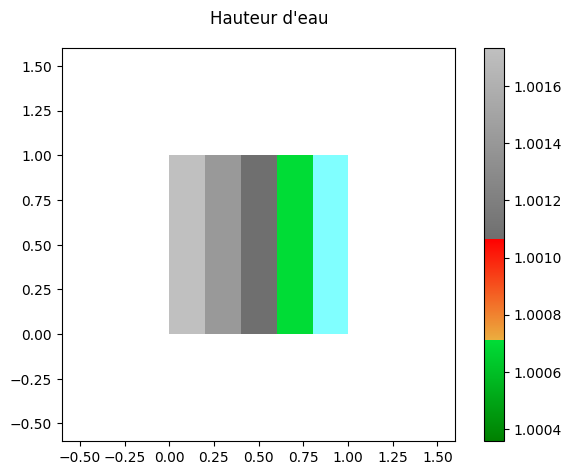

In [23]:

print('Minimum ', res[0].array.min())
print('Maximum ', res[0].array.max())

fig,ax = res[0].plot_matplotlib()
fig.suptitle('Hauteur d\'eau')
fig.colorbar(ax.images[0], ax=ax)
fig.tight_layout()


# Il est peut-être aussi temps d'ouvrir l'interface WOLF pour plus d'interactivité...